Saved figure as figures/dt_vs_dE25_h2o_color_noise.pdf


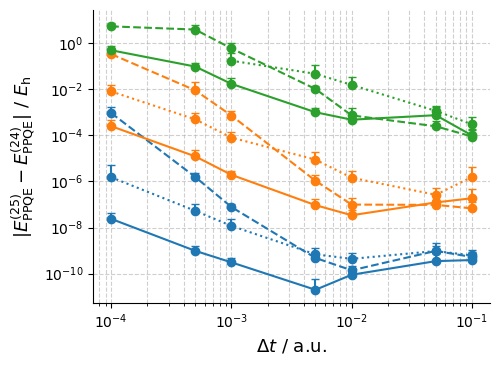

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"  # molecule string in filename

# Color palette for noise values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
plot_update_types = ['jl', 'tlr', 'tlrim']
dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
noise_pattern = re.compile(r"noise_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")

# --- Gather all files ---
all_files = glob.glob(f"runs_data_v1/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize data: {noise: {update_type: {dt: [|dE_25|, ...]}}} ---
data = defaultdict(lambda: {ut: defaultdict(list) for ut in plot_update_types})

for fname in all_files:
    # Parse dt, noise, update_type
    dt_m = dt_pattern.search(fname)
    noise_m = noise_pattern.search(fname)
    update_m = update_pattern.search(fname)
    if not (dt_m and noise_m and update_m):
        continue
    dt = float(dt_m.group(1))
    noise = float(noise_m.group(1))
    update_type = update_m.group(1)
    if update_type not in plot_update_types:
        continue

    # Read last (25th) dE value (3rd column)
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    if len(lines) < 25:
        continue
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    # dE_25 = np.abs(arr[-1, 2])
    dE_25 = np.abs(arr[19, 2])
    data[noise][update_type][dt].append(dE_25)

# --- Assign a color to each noise value ---
noise_vals = sorted(data.keys())
noise_to_color = {noise: color_list[i % len(color_list)] for i, noise in enumerate(noise_vals)}

# --- Plot: log(avg |dE_25|) vs log(dt), error bars are std dev over 10 runs ---
# plt.figure(figsize=(6, 4.2))
plt.figure(figsize=(5.1, 3.75))

for i, noise in enumerate(noise_vals):
    color = noise_to_color[noise]
    for ut in plot_update_types:
        dts = sorted(data[noise][ut].keys())
        if not dts:
            continue
        avg_dEs = []
        std_dEs = []
        for dt in dts:
            vals = data[noise][ut][dt]
            avg_dEs.append(np.mean(vals))
            std_dEs.append(np.std(vals))
        label = f"Noise={noise:.1e}, {update_types[ut]['label']}"
        
        # plt.errorbar(
        #     dts, avg_dEs, yerr=std_dEs, marker='o',
        #     linestyle=update_types[ut]['linestyle'],
        #     color=color,
        #     label=label,
        #     capsize=3
        # )

        plt.errorbar(
            dts, avg_dEs, 
            yerr=[np.zeros_like(std_dEs), std_dEs],  # Only upper error bars
            marker='o',
            linestyle=update_types[ut]['linestyle'],
            color=color,
            label=label,
            capsize=3
        )

plt.xscale('log')
plt.yscale('log')


plt.xlabel(r"$\Delta t$ / a.u.", fontsize=13)
plt.ylabel(r"$|E_\mathrm{PPQE}^{(25)} - E_\mathrm{PPQE}^{(24)}| ~/ ~E_\mathrm{h}$", fontsize=13)


plt.grid(True, which='both', ls='--', alpha=0.6)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# plt.xlabel(r"Time Step $\Delta t$", fontsize=13)
# plt.ylabel(r"$|dE|$ at 25th iter (mean $\pm$ std)", fontsize=13)
# plt.title(f"PPQE: Time Step vs. $|dE|$ (25th iter) for {sys_str.upper()}", fontsize=14)
# plt.legend(fontsize=9, loc='best')

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/dt_vs_dE25_{sys_str}_color_noise.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

Saved figure as figures/resid_vs_dE_h2o_color_dt.pdf


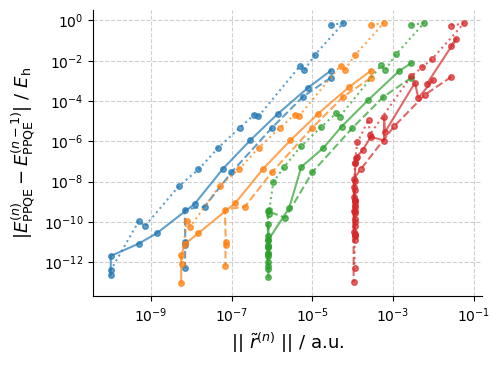

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"  # molecule string in filename

# Specify which time steps to include (set to None to include all)
# include_dt = None  # Example: [1.0e-4, 1.0e-3, 1.0e-2] or None for all
include_dt = [1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1] 

# Color palette for dt values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
plot_update_types = ['jl', 'tlr', 'tlrim']
dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")

# --- Gather all files ---
all_files = glob.glob(f"noisless_data/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize data: {dt: {update_type: [ (log_resid, abs_dE), ... ] }} ---
data = defaultdict(lambda: {ut: [] for ut in plot_update_types})

for fname in all_files:
    # Parse dt, update_type
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    if not (dt_m and update_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    if update_type not in plot_update_types:
        continue
    if include_dt is not None and dt not in include_dt:
        continue

    # Read all lines, skip comments
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    if len(lines) < 2:
        continue
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]

    # For each iteration except the last, get (log_resid, abs_dE_next)
    for i in range(len(arr) - 1):
        resid_norm = arr[i, -2]
        dE_next = np.abs(arr[i+1, 2])
        if resid_norm > 0:
            # data[dt][update_type].append((np.log10(resid_norm), dE_next))
            data[dt][update_type].append((resid_norm, dE_next))

# --- Assign a color to each dt ---
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

# --- Plot ---
# plt.figure(figsize=(7, 4.5))
plt.figure(figsize=(5.1, 3.75))

for dt in dt_vals:
    color = dt_to_color[dt]
    for ut in plot_update_types:
        points = data[dt][ut]
        if not points:
            continue
        x, y = zip(*points)
        label = f"$\Delta t$={dt:.2e}, {update_types[ut]['label']}"
        plt.plot(
            x, y, marker='o', linestyle=update_types[ut]['linestyle'],
            color=color, label=label, alpha=0.7, markersize=4
        )


# # Print which files were used (non-empty data sets)
# print("Files used to populate data:")
# for dt in data:
#     for ut in data[dt]:
#         if data[dt][ut]:
#             print(f"  dt={dt}, update_type={ut}: {len(data[dt][ut])} points")

# # Optionally, print a sample of the data for a specific dt and update_type
# print("\nSample data for each dt and update_type (first 3 points):")
# for dt in data:
#     for ut in data[dt]:
#         if data[dt][ut]:
#             print(f"dt={dt}, update_type={ut}: {data[dt][ut][:3]}")

# plt.xlabel(r"Residual Norm ($||r||$)", fontsize=13)
# plt.ylabel(r"$|dE|$ (next iter)", fontsize=13)
# plt.yscale('log')
# plt.xscale('log')
# plt.title(f"PPQE: Residual Norm vs. $|dE|$ (next iter) for {sys_str.upper()}", fontsize=14)
# plt.grid(True, which='both', ls='--', alpha=0.6)
# plt.tight_layout()
# plt.legend(fontsize=9, loc='best', ncol=2)

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"$||~ \tilde{r}^{(n)} ~||$ / a.u.", fontsize=13)
plt.ylabel(r"$|E_\mathrm{PPQE}^{(n)} - E_\mathrm{PPQE}^{(n-1)}| ~/ ~E_\mathrm{h}$", fontsize=13)

plt.grid(True, which='both', ls='--', alpha=0.6)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/resid_vs_dE_{sys_str}_color_dt.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

Saved figure as figures/resid_vs_dE_h2o_tlrim_color_dt_with_fit.pdf


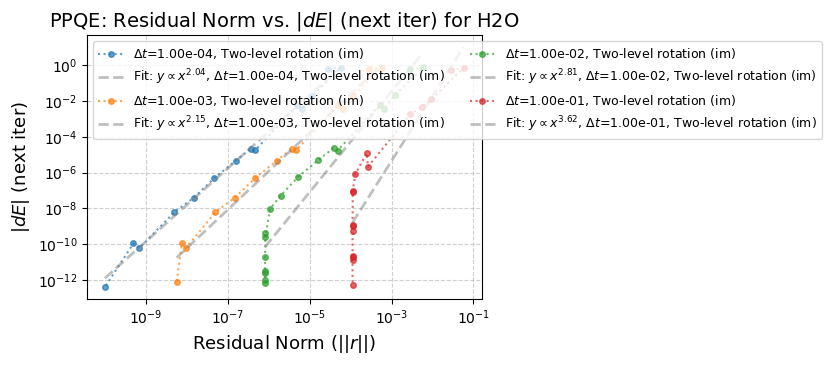

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os
from scipy.optimize import curve_fit

# --- User options ---
sys_str = "h2o"  # molecule string in filename

# Specify which time steps to include (set to None to include all)
include_dt = [1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1]  # or None for all

# Specify which update types to include (set to None to include all)
# Example: ['jl', 'tlr'] or None for all
# include_update_types = ['jl']
# include_update_types = ['tlr']
include_update_types = ['tlrim']
# include_update_types = ['jl', 'tlr']
# include_update_types = ['jl', 'tlr', 'tlrim']

# Color palette for dt values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
all_update_types = ['jl', 'tlr', 'tlrim']
if include_update_types is None:
    plot_update_types = all_update_types
else:
    plot_update_types = [ut for ut in include_update_types if ut in all_update_types]

dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")

# --- Gather all files ---
all_files = glob.glob(f"noisless_data/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize data: {dt: {update_type: [ (log_resid, abs_dE), ... ] }} ---
data = defaultdict(lambda: {ut: [] for ut in plot_update_types})

for fname in all_files:
    # Parse dt, update_type
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    if not (dt_m and update_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    if update_type not in plot_update_types:
        continue
    if include_dt is not None and dt not in include_dt:
        continue

    # Read all lines, skip comments
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    if len(lines) < 2:
        continue
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]

    # For each iteration except the last, get (log_resid, abs_dE_next)
    for i in range(len(arr) - 1):
        resid_norm = arr[i, -2]
        dE_next = np.abs(arr[i+1, 2])
        if resid_norm > 0:
            data[dt][update_type].append((resid_norm, dE_next))

# --- Assign a color to each dt ---
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

# --- Plot ---
# plt.figure(figsize=(7, 4.5))
plt.figure(figsize=(5.1, 3.75))

def power_law(x, n, a):
    return a * x**n

for dt in dt_vals:
    color = dt_to_color[dt]
    for ut in plot_update_types:
        points = data[dt][ut]
        if not points:
            continue
        x, y = zip(*points)
        x = np.array(x)
        y = np.array(y)
        label = f"$\Delta t$={dt:.2e}, {update_types[ut]['label']}"
        plt.plot(
            x, y, marker='o', linestyle=update_types[ut]['linestyle'],
            color=color, label=label, alpha=0.7, markersize=4
        )

        # Fit y = a * x^n in log-log space
        mask = (x > 0) & (y > 0)
        if np.sum(mask) > 2:
            logx = np.log10(x[mask])
            logy = np.log10(y[mask])
            # Linear fit: logy = n*logx + loga
            coeffs = np.polyfit(logx, logy, 1)
            n_fit = coeffs[0]
            a_fit = 10**coeffs[1]
            # For plotting the fit line
            x_fit = np.logspace(np.log10(x[mask].min()), np.log10(x[mask].max()), 100)
            y_fit = a_fit * x_fit**n_fit
            # plt.plot(
            #     x_fit, y_fit, linestyle=update_types[ut]['linestyle'],
            #     color=color, alpha=0.5, linewidth=2,
            #     label=f"Fit: $y \\propto x^{{{n_fit:.2f}}}$, $\Delta t$={dt:.2e}, {update_types[ut]['label']}"
            # )
            plt.plot(
                x_fit, y_fit, linestyle='dashed',
                color='gray', alpha=0.5, linewidth=2,
                label=f"Fit: $y \\propto x^{{{n_fit:.2f}}}$, $\Delta t$={dt:.2e}, {update_types[ut]['label']}"
            )
            

plt.xlabel(r"Residual Norm ($||r||$)", fontsize=13)
plt.ylabel(r"$|dE|$ (next iter)", fontsize=13)
plt.yscale('log')
plt.xscale('log')
plt.title(f"PPQE: Residual Norm vs. $|dE|$ (next iter) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.legend(fontsize=9, loc='upper left', ncol=2)

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/resid_vs_dE_{sys_str}_{include_update_types[0]}_color_dt_with_fit.pdf"
plt.savefig(output_pdf)
print(f"Saved figure as {output_pdf}")

plt.show()

Saved figure as figures/deltaresid_vs_dE_h2o_color_dt_with_fit.pdf


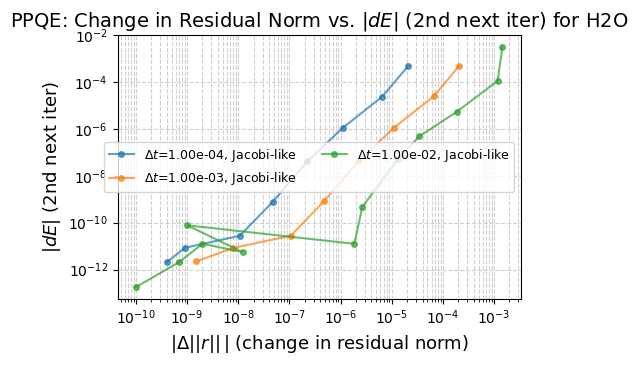

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict
import os

# --- User options ---
sys_str = "h2o"  # molecule string in filename

# Specify which time steps to include (set to None to include all)
include_dt = [1.0e-4, 1.0e-3, 1.0e-2]  # or None for all

# Specify which update types to include (set to None to include all)
# Example: ['jl', 'tlr'] or None for all
# include_update_types = ['tlrim']  # or None for all
include_update_types = ['jl']
# include_update_types = ['tlr']
# include_update_types = ['tlrim']
# include_update_types = ['jl', 'tlr']
# include_update_types = ['jl', 'tlr', 'tlrim']

# Color palette for dt values (expand as needed)
color_list = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
    'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

update_types = {
    'jl':   {'label': 'Jacobi-like',           'linestyle': 'solid'},
    'tlr':  {'label': 'Two-level rotation',    'linestyle': 'dashed'},
    'tlrim':{'label': 'Two-level rotation (im)','linestyle': 'dotted'},
}
all_update_types = ['jl', 'tlr', 'tlrim']
if include_update_types is None:
    plot_update_types = all_update_types
else:
    plot_update_types = [ut for ut in include_update_types if ut in all_update_types]

dt_pattern = re.compile(r"dt_([0-9.eE+-]+)")
update_pattern = re.compile(r"updt_([a-z]+)")

# --- Gather all files ---
all_files = glob.glob(f"noisless_data/ppqe_{sys_str}_dt_*_updt_*_noise_*_r_*.dat")

# --- Organize data: {dt: {update_type: [ (abs_delta_resid, abs_dE_next), ... ] }} ---
data = defaultdict(lambda: {ut: [] for ut in plot_update_types})

for fname in all_files:
    # Parse dt, update_type
    dt_m = dt_pattern.search(fname)
    update_m = update_pattern.search(fname)
    if not (dt_m and update_m):
        continue
    dt = float(dt_m.group(1))
    update_type = update_m.group(1)
    if update_type not in plot_update_types:
        continue
    if include_dt is not None and dt not in include_dt:
        continue

    # Read all lines, skip comments
    with open(fname, "r") as f:
        lines = [line for line in f if not line.strip().startswith("#") and line.strip()]
    if len(lines) < 3:
        continue
    arr = np.loadtxt(lines)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]

    # For each iteration except the last two, get (abs_delta_resid, abs_dE_next)
    for i in range(len(arr) - 2):
        resid_norm_i = arr[i, -2]
        resid_norm_ip1 = arr[i+1, -2]
        dE_next = np.abs(arr[i+2, 2])
        abs_delta_resid = np.abs(resid_norm_ip1 - resid_norm_i)
        if abs_delta_resid > 0:
            data[dt][update_type].append((abs_delta_resid, dE_next))

# --- Assign a color to each dt ---
dt_vals = sorted(data.keys())
dt_to_color = {dt: color_list[i % len(color_list)] for i, dt in enumerate(dt_vals)}

# --- Plot ---
# plt.figure(figsize=(7, 4.5))
plt.figure(figsize=(5.1, 3.75))

def power_law(x, n, a):
    return a * x**n

for dt in dt_vals:
    color = dt_to_color[dt]
    for ut in plot_update_types:
        points = data[dt][ut]
        if not points:
            continue
        x, y = zip(*points)
        x = np.array(x)
        y = np.array(y)
        label = f"$\Delta t$={dt:.2e}, {update_types[ut]['label']}"
        plt.plot(
            x, y, marker='o', linestyle=update_types[ut]['linestyle'],
            color=color, label=label, alpha=0.7, markersize=4
        )

        # Fit y = a * x^n in log-log space
        mask = (x > 0) & (y > 0)
        if np.sum(mask) > 2:
            logx = np.log10(x[mask])
            logy = np.log10(y[mask])
            coeffs = np.polyfit(logx, logy, 1)
            n_fit = coeffs[0]
            a_fit = 10**coeffs[1]
            x_fit = np.logspace(np.log10(x[mask].min()), np.log10(x[mask].max()), 100)
            y_fit = a_fit * x_fit**n_fit
            # plt.plot(
            #     x_fit, y_fit, linestyle=update_types[ut]['linestyle'],
            #     color=color, alpha=0.5, linewidth=2,
            #     label=f"Fit: $y \\propto x^{{{n_fit:.2f}}}$, $\Delta t$={dt:.2e}, {update_types[ut]['label']}"
            # )

plt.xlabel(r"$|\Delta ||r||\,|$ (change in residual norm)", fontsize=13)
plt.ylabel(r"$|dE|$ (2nd next iter)", fontsize=13)
plt.yscale('log')
plt.xscale('log')
plt.title(f"PPQE: Change in Residual Norm vs. $|dE|$ (2nd next iter) for {sys_str.upper()}", fontsize=14)
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.tight_layout()
plt.legend(fontsize=9, loc='best', ncol=2)

# --- Save figure ---
os.makedirs("figures", exist_ok=True)
output_pdf = f"figures/deltaresid_vs_dE_{sys_str}_color_dt_with_fit.pdf"
plt.savefig(output_pdf)
# print(f"Saved figure as {output_pdf}")

plt.show()